# Trabajo Práctico 1

Estudiantes:

- Alonso Araya Calvo
- Pedro Soto
- Sofia Oviedo

# Imports

In [1]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.spatial.distance import jensenshannon
from sklearn.model_selection import train_test_split
from numpy import true_divide

# Cargando dataset

In [2]:
#tomado de https://www.kaggle.com/code/wailinnoo/intrusion-detection-system-using-kdd99-dataset
import pandas as pd
from tensorflow.keras.utils import get_file

try:
    path = get_file('kddcup.data_10_percent.gz',
                    origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
pd_data_frame = pd.read_csv(path, header=None)

# The CSV file has no column heads, so add them
pd_data_frame.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

2144903/2144903 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


# Limpieza del dataset y generación de subset del dataset

In [3]:
# For now, just drop NA's (rows with missing values), in case there are
pd_data_frame.dropna(inplace=True, axis=1)

# Checking for DUPLICATE values
pd_data_frame.drop_duplicates(keep='first', inplace=True)

In [4]:
# Filter the DataFrame to keep only 'normal.' and 'back.' outcomes
filtered_df = pd_data_frame[pd_data_frame['outcome'].isin(['normal.', 'back.'])].copy()

In [5]:
list_nominal_features = ["flag", "protocol_type", "service"]

# Apply one-hot encoding to the nominal features
df_encoded = pd.get_dummies(filtered_df, columns=list_nominal_features)

# Convert boolean columns (from one-hot encoding) to integers (0 or 1) in df_encoded
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

In [6]:
df_attacks = df_encoded[df_encoded['outcome'] == 'back.'].copy()
df_no_attacks = df_encoded[df_encoded['outcome'] == 'normal.'].copy()

# Funciones Utilitarias

In [7]:
# Util para mostrar dataframes completos sin el resumen que se hace por defecto
def display_dataframe_completely(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)

# Parte 1 Análisis descriptivo de las características en el conjunto

## 1a Análisis de momentos estadísticos

- Media
- Desviación estándar
- Inclinación
- Kurtosis

```
1. (15 puntos) Por cada característica del espacio de entrada, compute los
siguientes momentos estadísticos (usando la implementación de las funciones
correspondientes en pytorch, o la implementacion realizada por
su equipo): media, desviación estándar, inclinación y kurtosis. Presente
tales momentos de forma compacta y analice los resultados.
```

In [ ]:
# Es necesario eliminar la columna de outcome para poder utilizar el dataset en pytorch ya que es categorica 
# y no es necesario realmente tenerla para calculos numericos ya que al separar los datasets
# ya se sabe de cual clase proviene.
df_attacks_without_outcome = df_attacks.drop('outcome', axis=1)
df_normal_without_outcome = df_no_attacks.drop('outcome', axis=1)

attack_without_outcomes_column_names = df_attacks_without_outcome.columns
attack_tensor = torch.tensor(df_attacks_without_outcome.values, dtype=torch.float32)

normal_without_outcomes_column_names = df_normal_without_outcome.columns
no_attack_tensor = torch.tensor(df_normal_without_outcome.values, dtype=torch.float32)

In [9]:
def calculate_moments(dataset_tensor, feature_names):
    means = torch.mean(dataset_tensor, dim=0)
    stds = torch.std(dataset_tensor, dim=0)

    z = (dataset_tensor - means) / stds
    z = torch.where(torch.isfinite(z), z, torch.zeros_like(z))

    skews = torch.mean(z ** 3, dim=0)
    kurtosis = torch.mean(z ** 4, dim=0) - 3

    stats_df = pd.DataFrame({
        "Media": means.numpy(),
        "Desviación Estándar": stds.numpy(),
        "Inclinación": skews.numpy(),
        "Kurtosis": kurtosis.numpy()
    }, index=feature_names)

    # display(stats_df)
    display_dataframe_completely(stats_df)

### Momentos Estadísticos para Datos de Ataque

In [10]:
calculate_moments(attack_tensor, attack_without_outcomes_column_names)

,Media,Desviación Estándar,Inclinación,Kurtosis
duration,0.293388,1.660627,6.201858,39.309826
src_bytes,53666.890625,4722.463867,-6.375225,42.617065
dst_bytes,8129.908203,919.138550,-5.915853,35.871830
land,0.000000,0.000000,0.000000,-3.000000
wrong_fragment,0.000000,0.000000,0.000000,-3.000000
urgent,0.000000,0.000000,0.000000,-3.000000
hot,1.917355,0.314076,-3.661317,15.021400
num_failed_logins,0.000000,0.000000,0.000000,-3.000000
logged_in,1.000000,0.000000,0.000000,-3.000000
num_compromised,0.924587,0.264193,-3.210891,8.318419


### Momentos Estadísticos para Paquetes Normales

In [11]:
calculate_moments(no_attack_tensor, normal_without_outcomes_column_names)

,Media,Desviación Estándar,Inclinación,Kurtosis
duration,188.932388,1320.953003,10.840396,164.942474
src_bytes,1270.249146,36017.765625,59.171658,3578.733887
dst_bytes,3720.620850,39526.839844,70.640572,6578.882324
land,0.000011,0.003374,296.354523,87825.000000
wrong_fragment,0.000000,0.000000,0.000000,-3.000000
urgent,0.000034,0.010123,296.354523,87825.000000
hot,0.049299,0.903317,24.367807,661.993713
num_failed_logins,0.000205,0.021867,130.644180,19413.707031
logged_in,0.792627,0.405427,-1.443531,0.083783
num_compromised,0.031606,4.258875,176.780899,33631.015625


## 1b Histogramas y Distancia Jensen Shannon

```
2. (15 puntos) Por cada característica, grafique el histograma para la categoría
ataque (backdoor) y normal, y compute la distancia de Jensen-Shannon
entre ambas aproximaciones de las densidades. Realice los gráficos para
facilitar la comparación, y analice los resultados.
```

In [ ]:
def generate_feature_histogram_and_calculate_jensen_shannon(df_normal, df_backdoor, feature_names, bins=30):
    js_distances = []

    for feat in feature_names:
        # Se obtienen los valores numericos de las dos clases
        normal_df_values = df_normal[feat].values
        backdoor_df_values = df_backdoor[feat].values

        limits_histogram = (min(normal_df_values.min(), backdoor_df_values.min()),
                            max(normal_df_values.max(), backdoor_df_values.max()))

        # Se calcula el histograma de las dos clases y se normaliza para obtener las densidades
        hist_normal, _ = np.histogram(normal_df_values, bins=bins, range=limits_histogram)
        hist_backdoor, _ = np.histogram(backdoor_df_values, bins=bins, range=limits_histogram)

        hist_normal = hist_normal / hist_normal.sum()
        hist_backdoor = hist_backdoor / hist_backdoor.sum()

        jsd = jensenshannon(hist_normal, hist_backdoor)
        js_distances.append(jsd)

        plt.figure(figsize=(6, 4))
        plt.hist(normal_df_values, bins=bins, range=limits_histogram, alpha=0.5, label="Normal", color='blue',
                 density=True)
        plt.hist(backdoor_df_values, bins=bins, range=limits_histogram, alpha=0.5, label="Backdoor", color='red',
                 density=True)
        plt.title(f"Histograma de {feat} (Distancia JS: {jsd:.4f})")
        plt.xlabel("Valor")
        plt.ylabel("Densidad")
        plt.legend()
        plt.show()

    # Dataframe con tabla de distancias de Jensen Shannon para todas las features
    js_df = pd.DataFrame({
        "Feature": feature_names,
        "DistanciaJS": js_distances
    }).sort_values(by="DistanciaJS", ascending=False)

    # display(js_df)
    display_dataframe_completely(js_df)

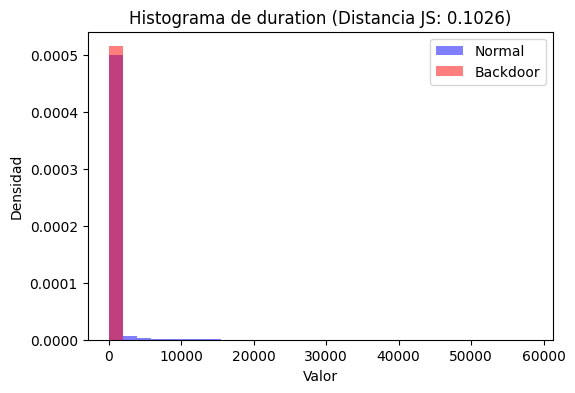

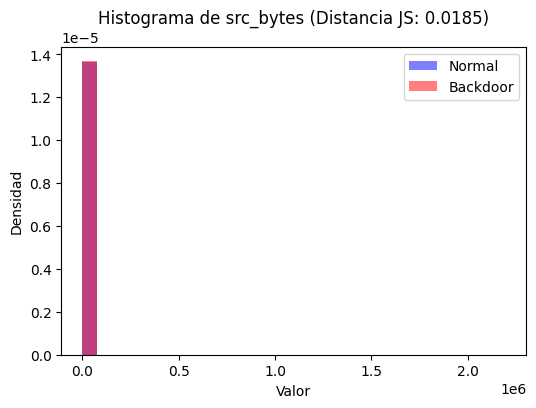

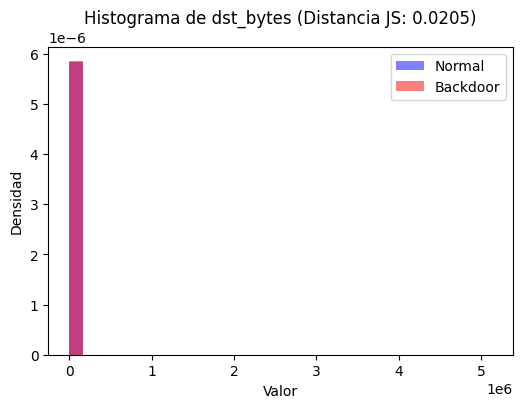

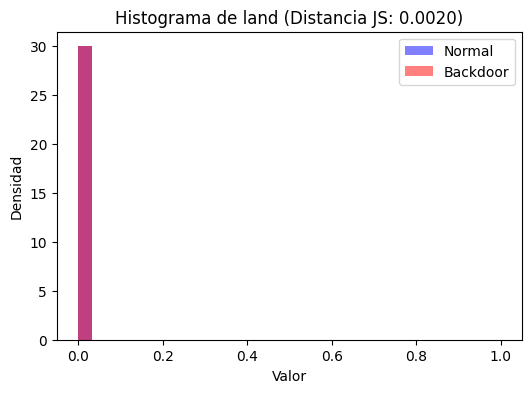

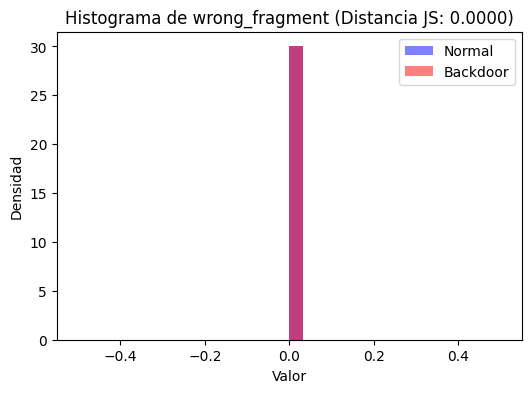

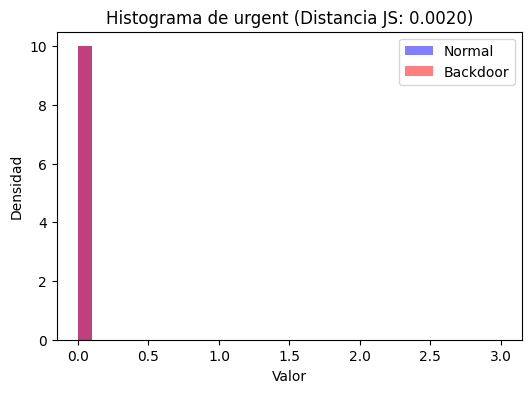

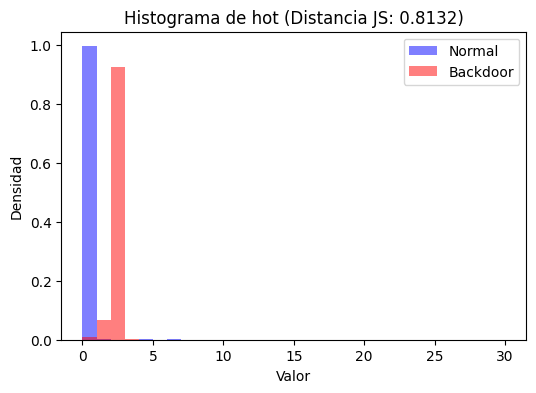

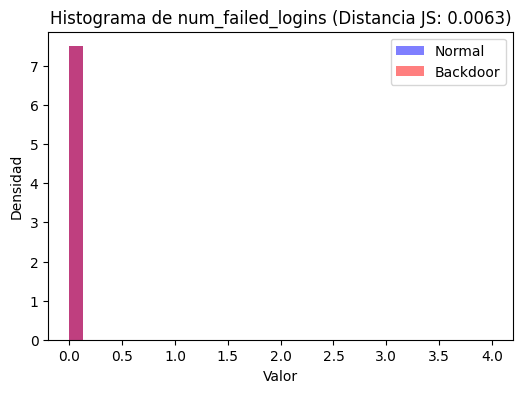

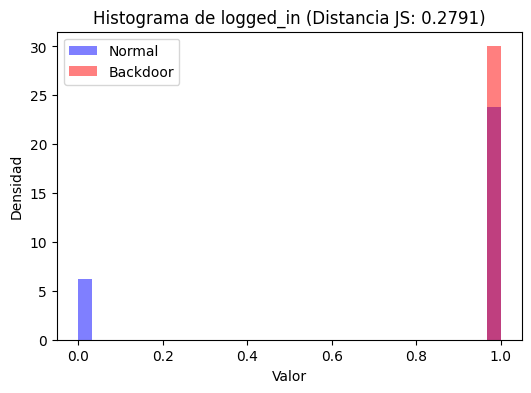

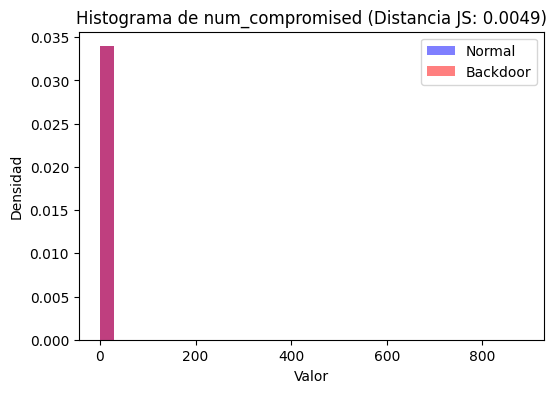

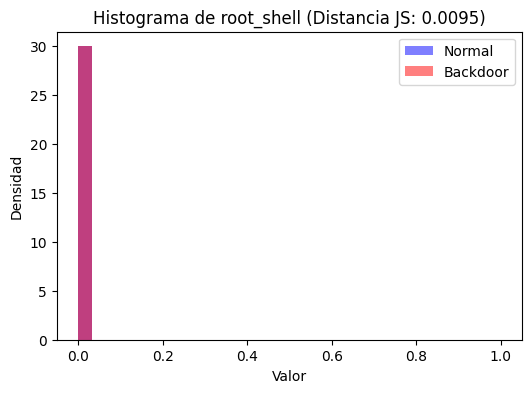

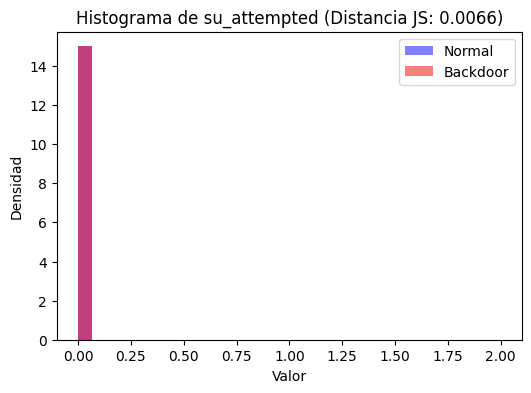

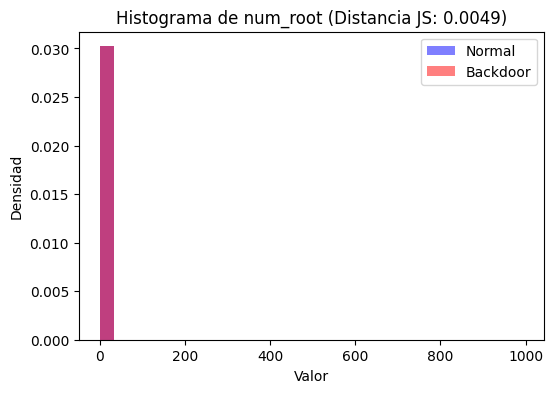

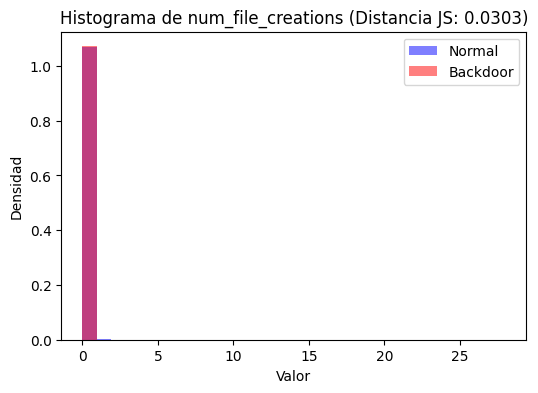

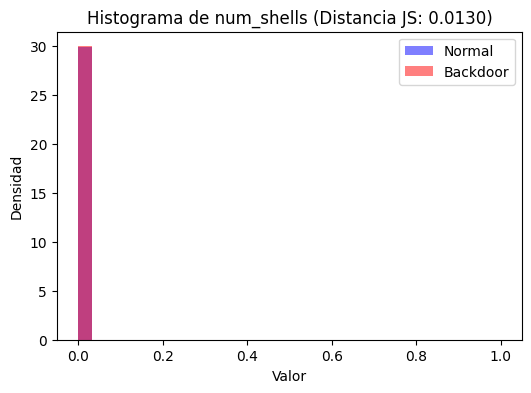

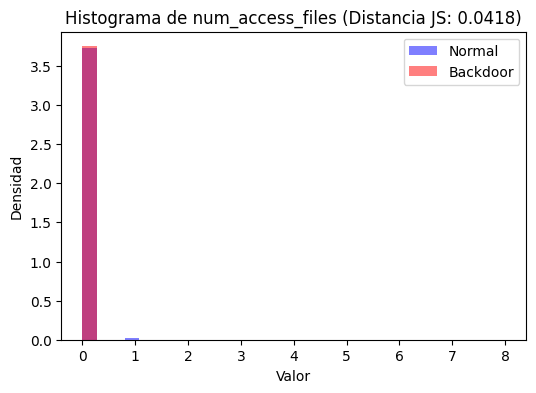

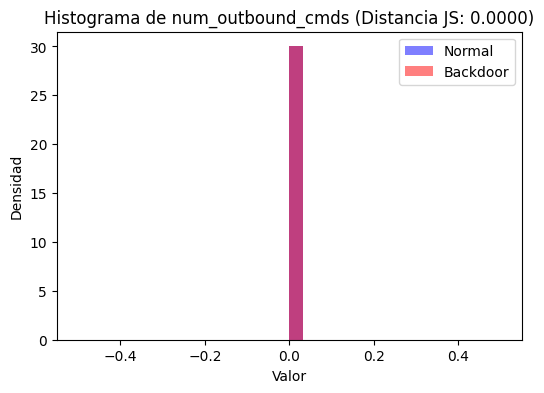

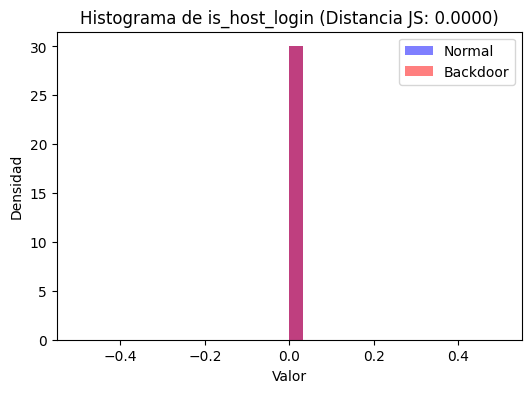

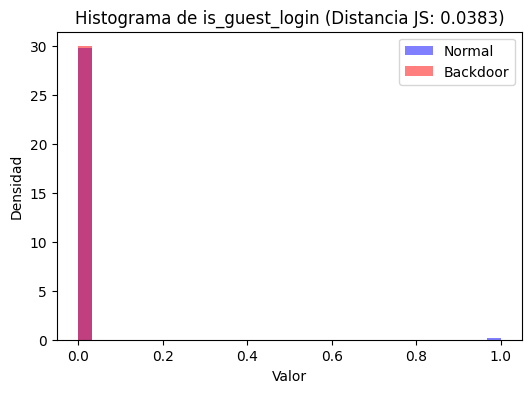

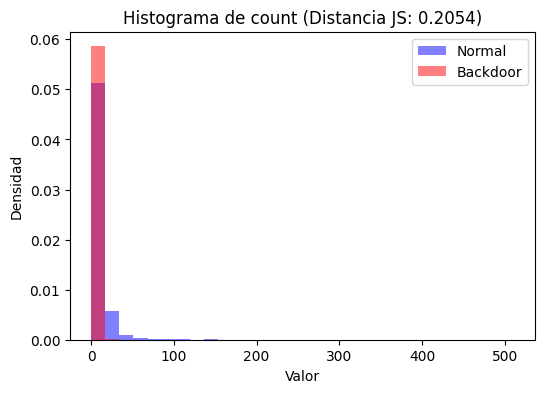

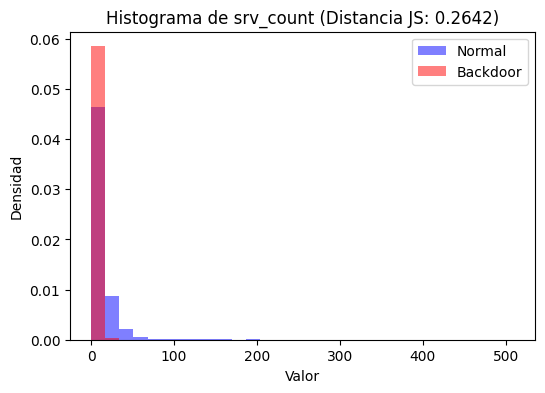

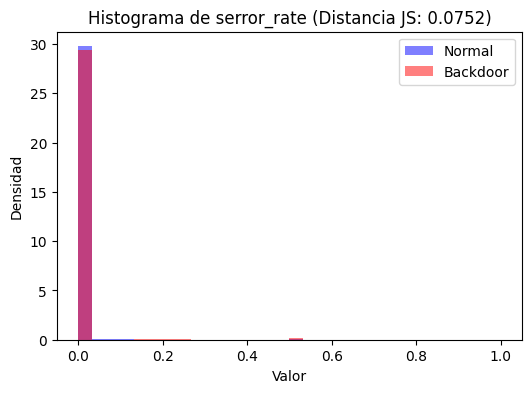

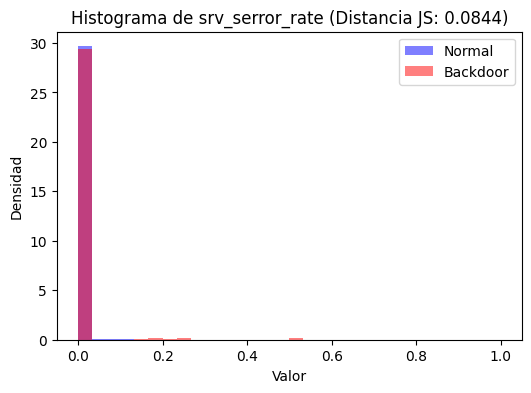

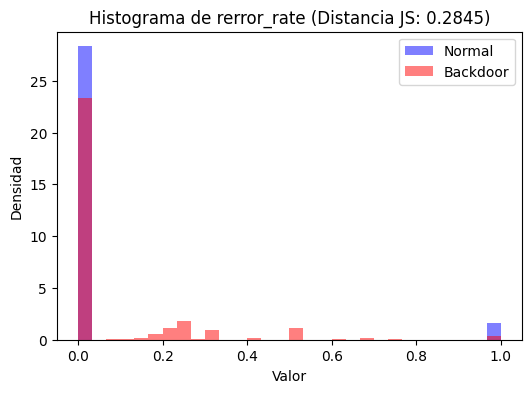

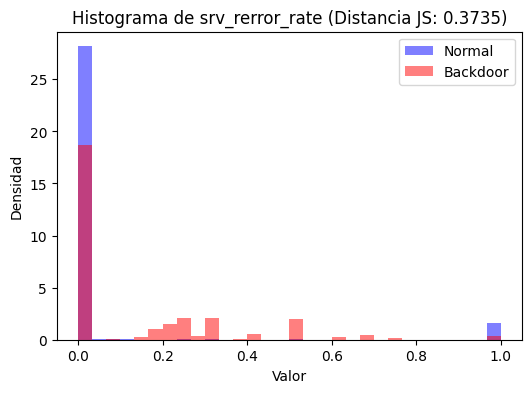

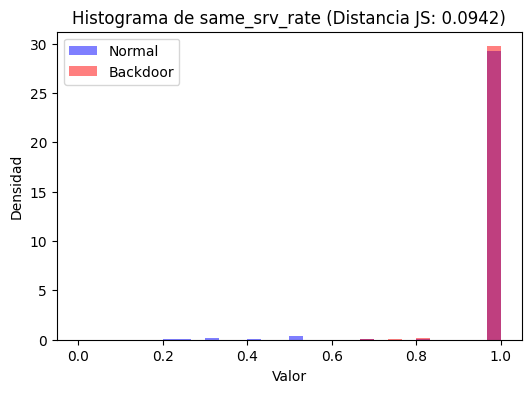

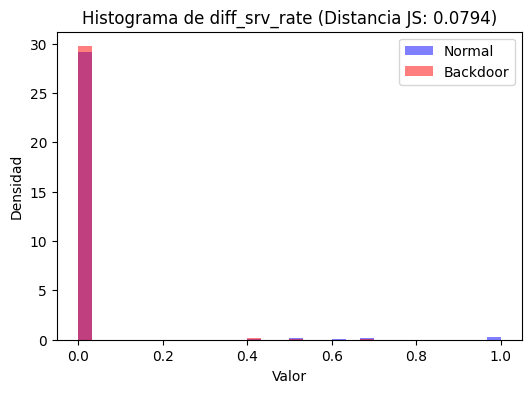

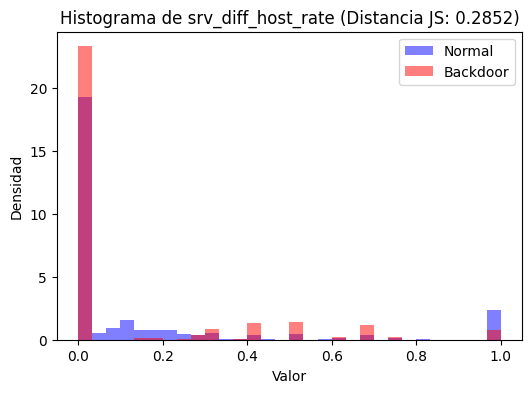

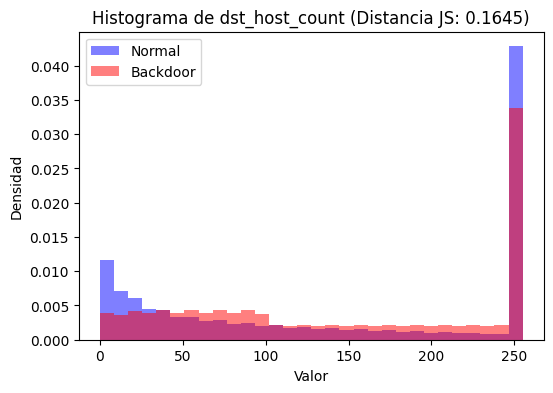

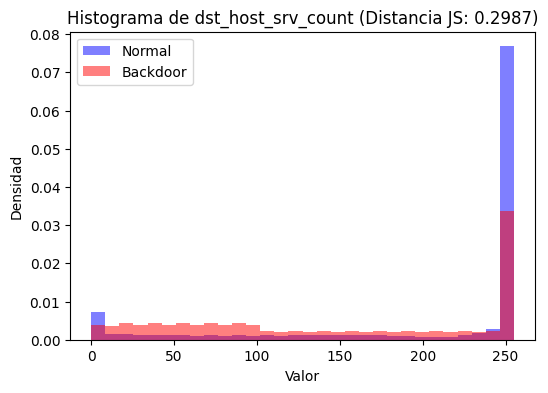

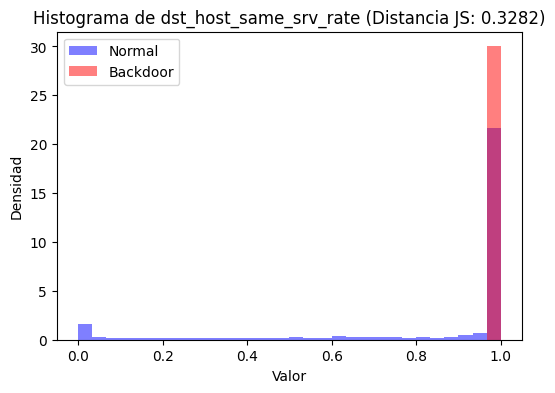

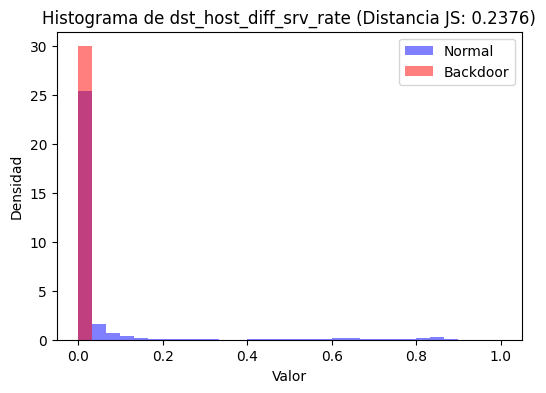

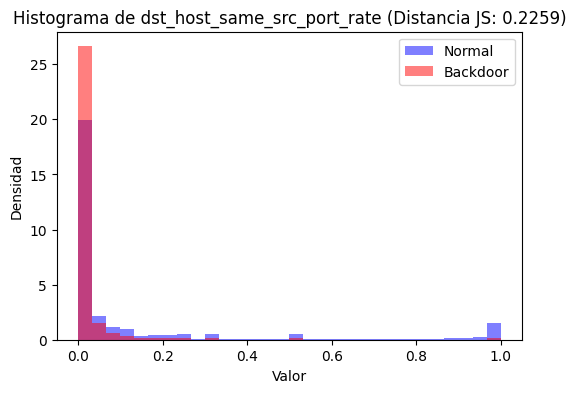

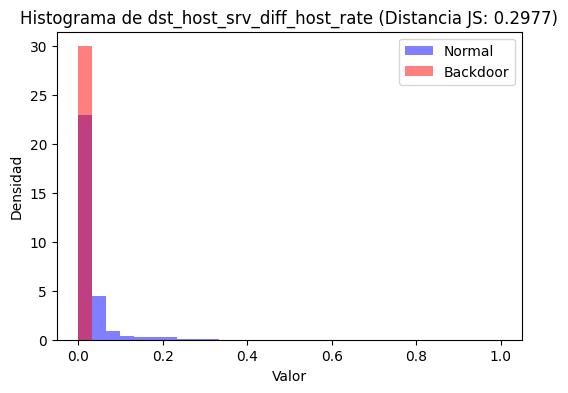

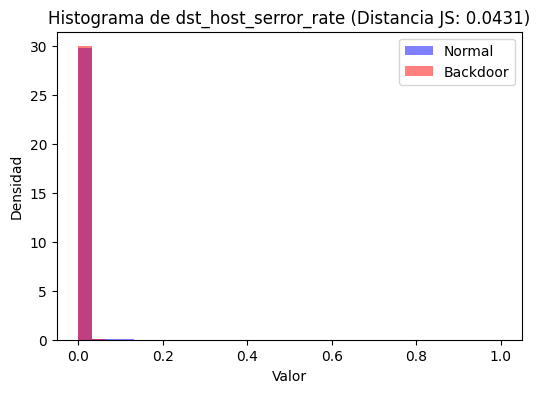

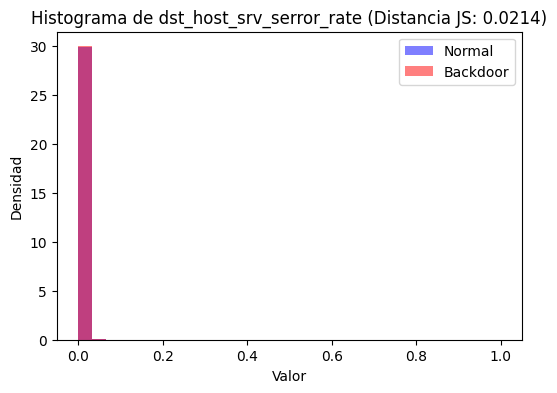

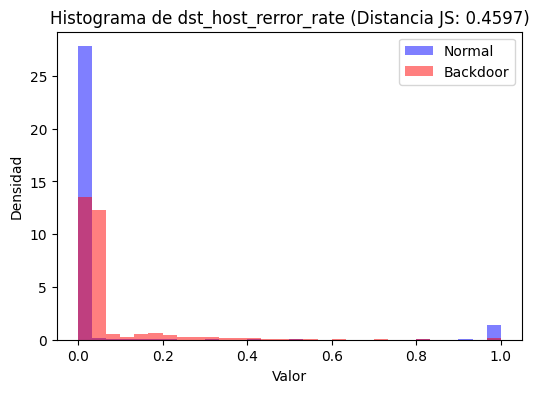

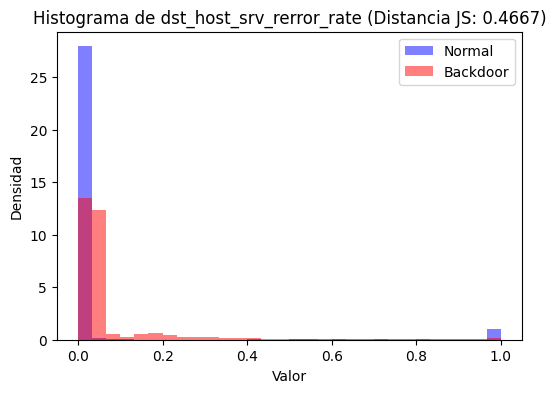

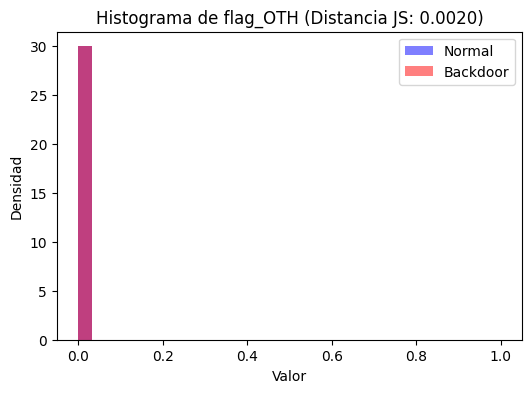

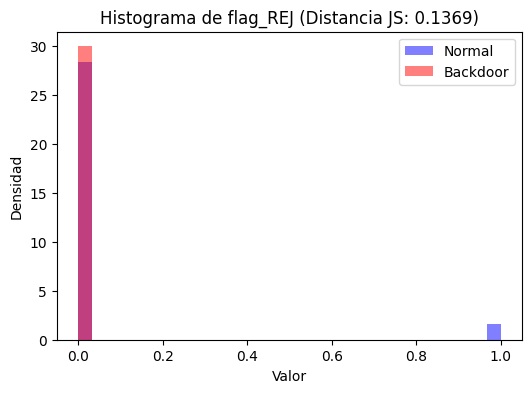

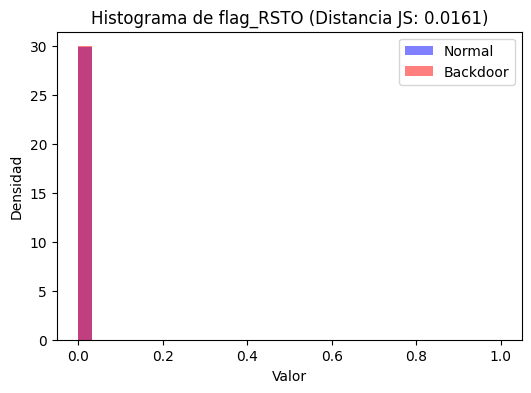

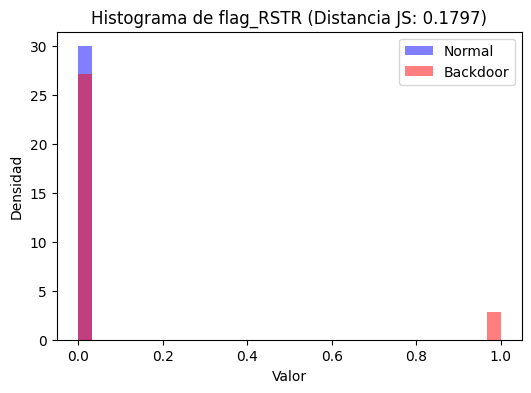

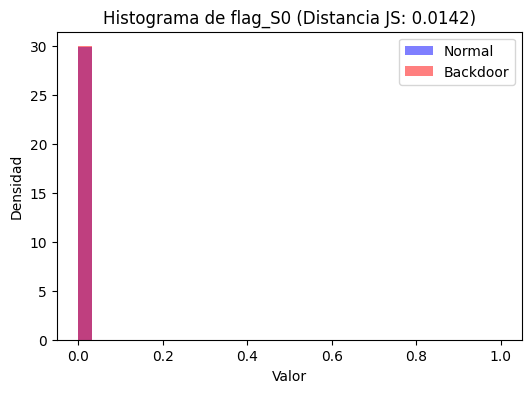

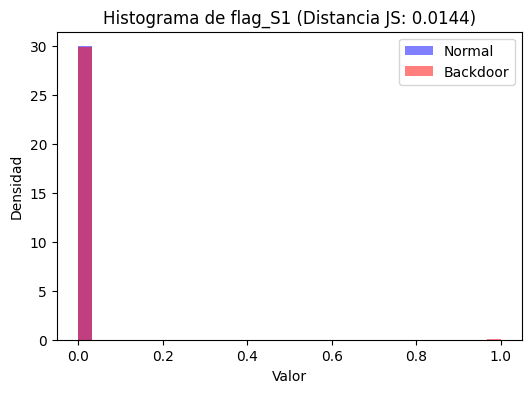

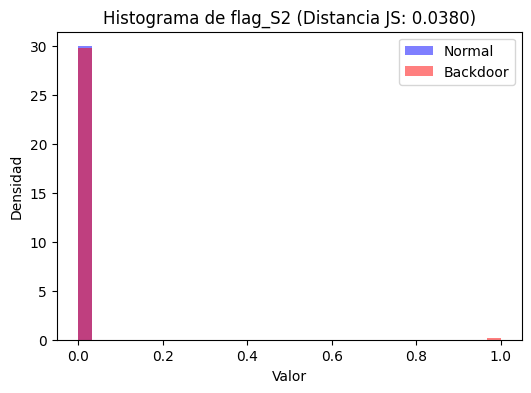

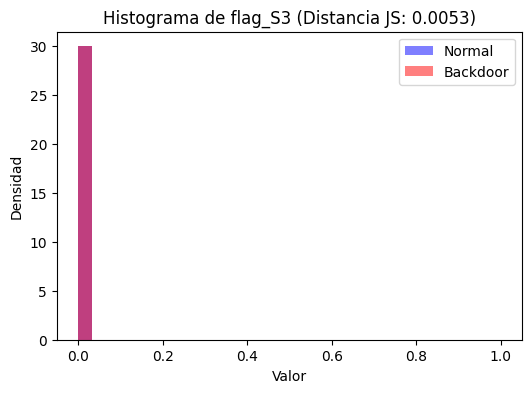

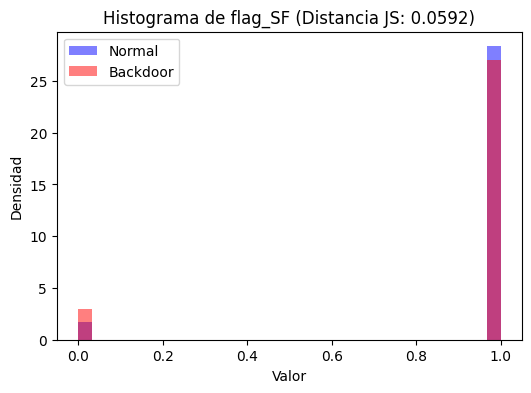

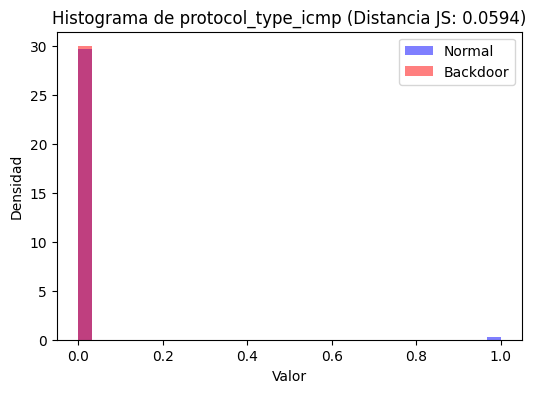

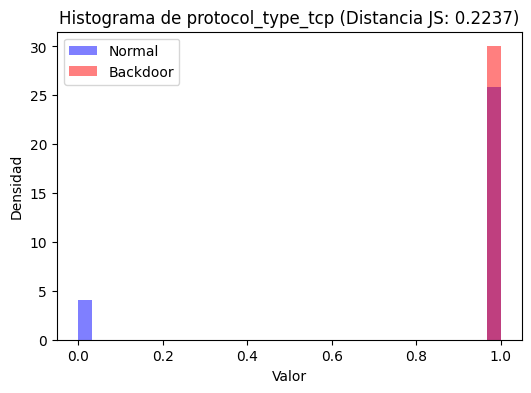

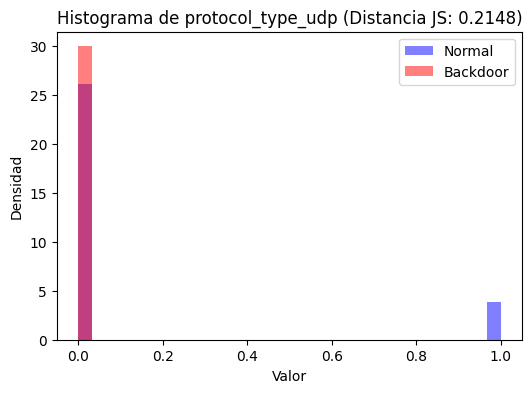

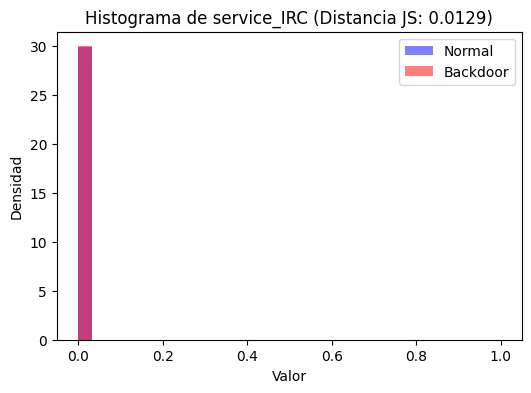

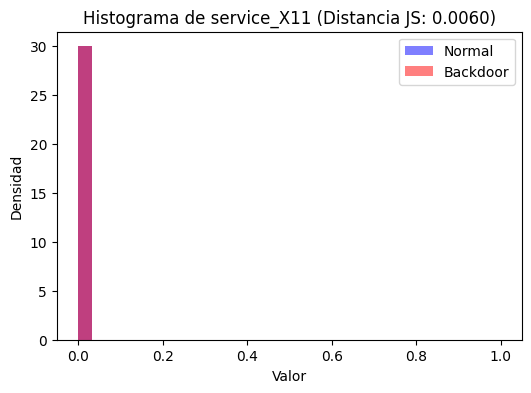

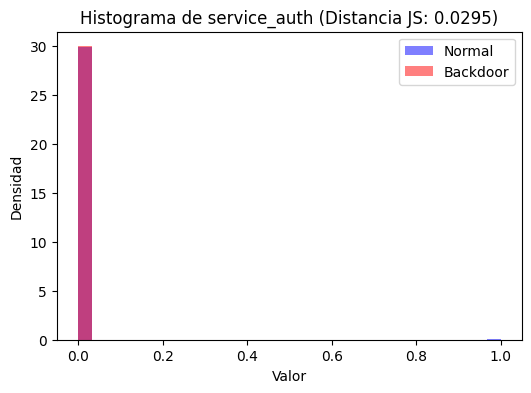

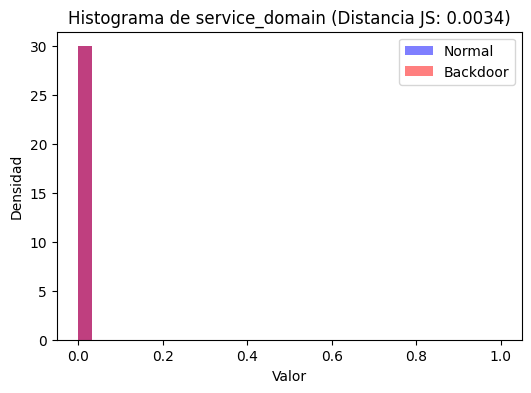

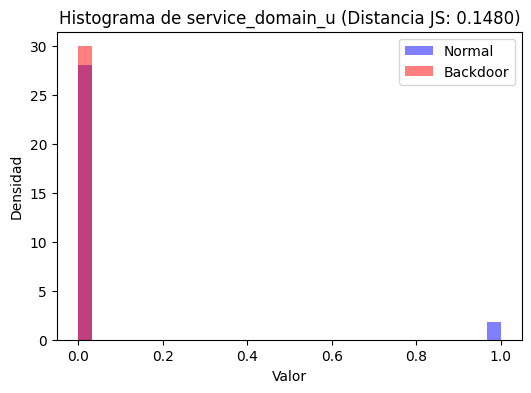

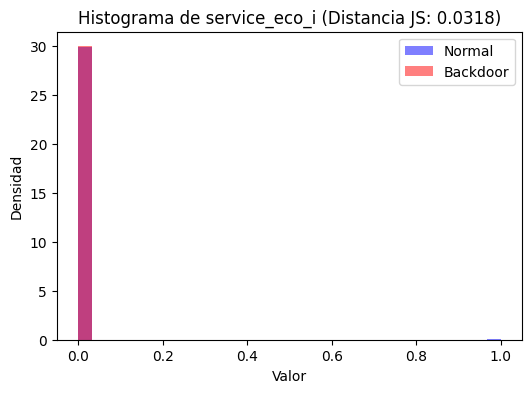

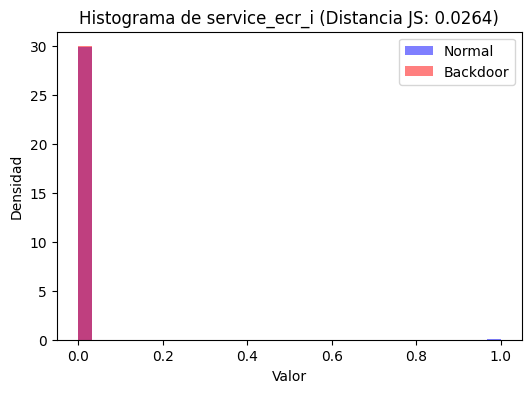

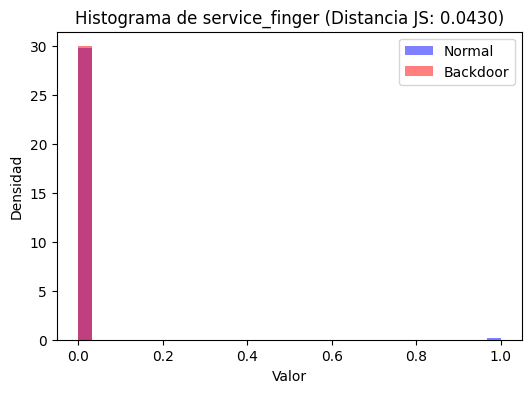

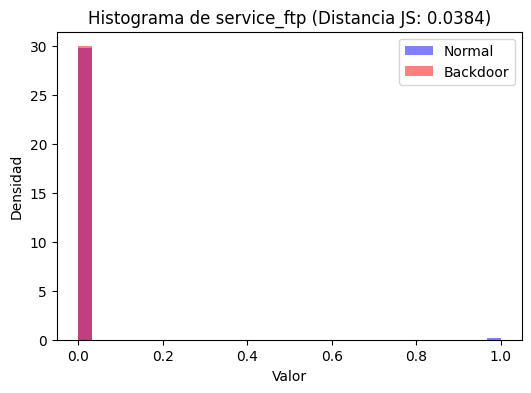

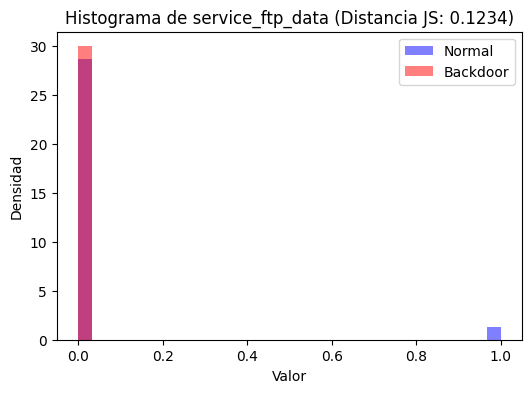

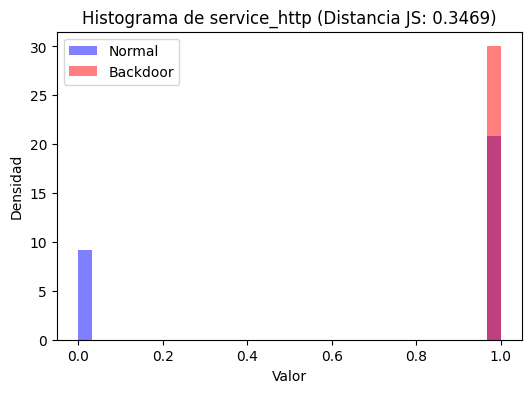

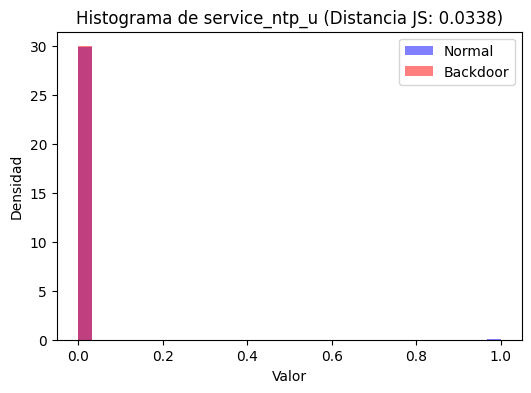

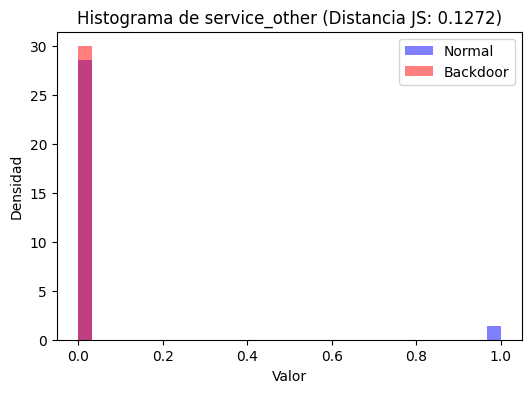

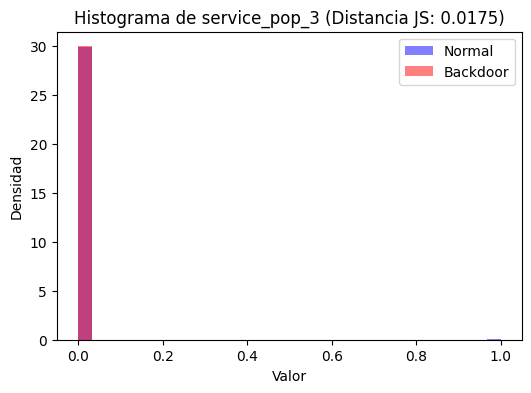

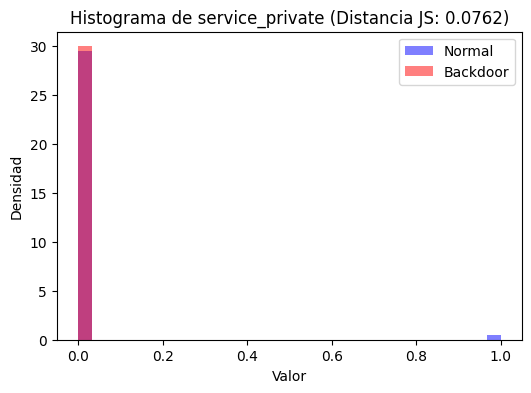

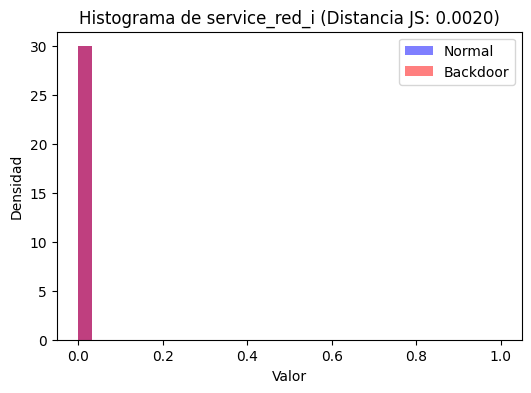

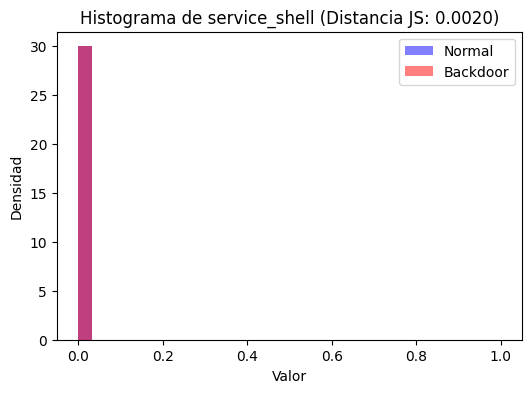

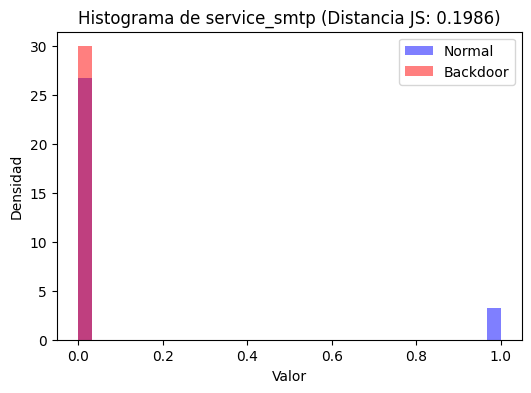

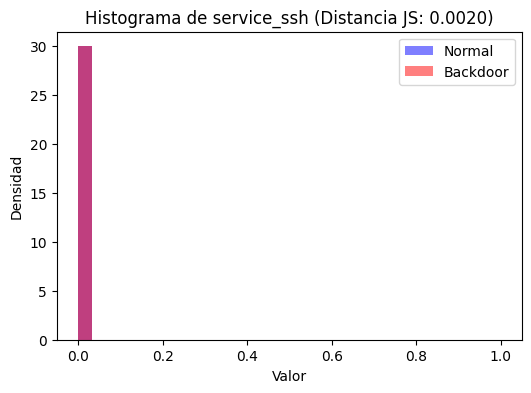

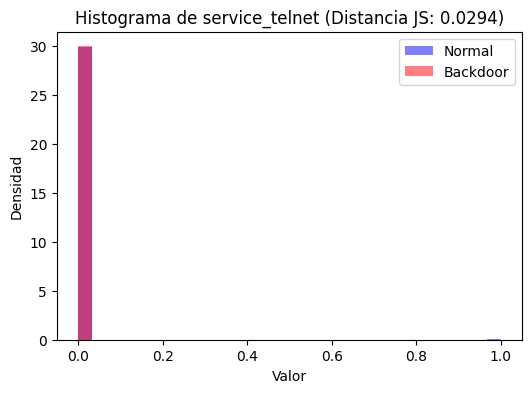

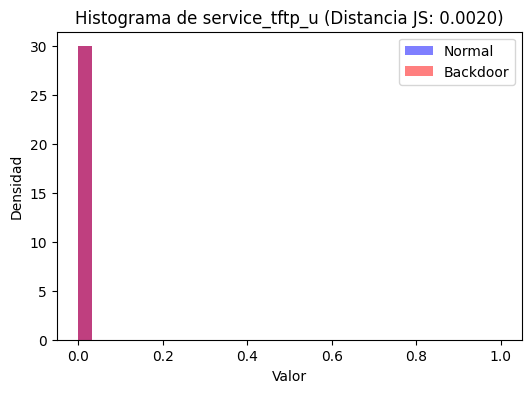

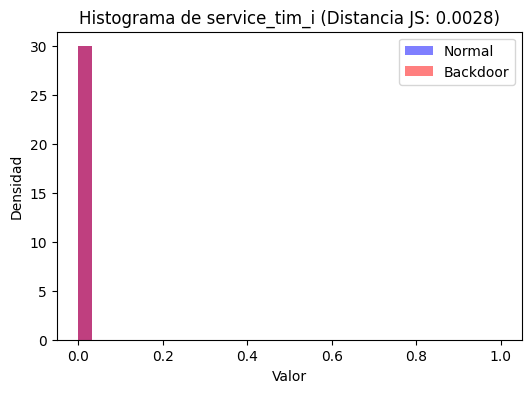

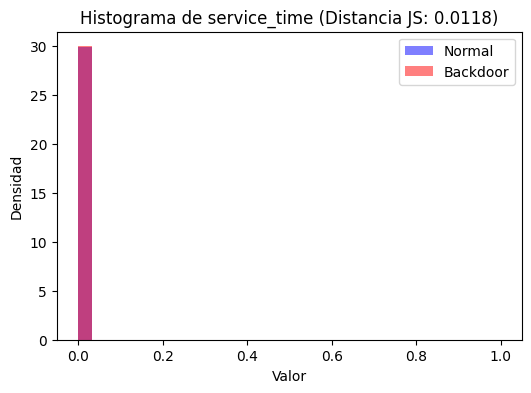

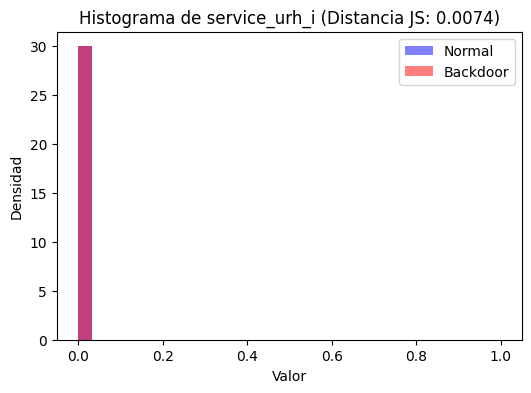

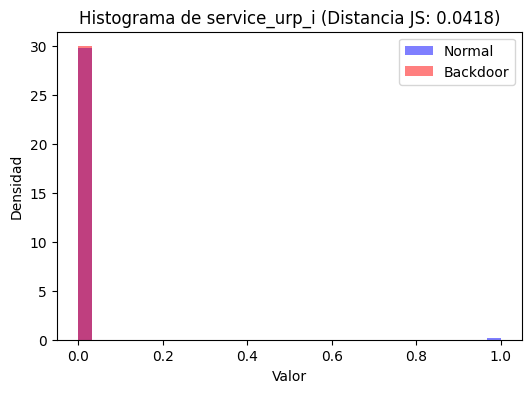

,Feature,DistanciaJS
6,hot,0.813179
37,dst_host_srv_rerror_rate,0.466678
36,dst_host_rerror_rate,0.459732
24,srv_rerror_rate,0.373477
60,service_http,0.346864
30,dst_host_same_srv_rate,0.328221
29,dst_host_srv_count,0.298668
33,dst_host_srv_diff_host_rate,0.297726
27,srv_diff_host_rate,0.285225
23,rerror_rate,0.284472


In [13]:
generate_feature_histogram_and_calculate_jensen_shannon(df_normal_without_outcome, df_attacks_without_outcome,
                                                        attack_without_outcomes_column_names)

# Parte 2 Implementación de la clasificación multi-clase con árboles de decisión

```
1. Para realizar la clasificación entre los ataques backdoor y las conexiones
normales, su equipo implementará los árboles de decisión. El código provisto
define las clases CART y Node_CART, las cuales permiten construir
un CART binario. Cada nodo del arbol tiene atributos como el feature, el
umbral, y el coeficiente de gini (o la entropía) de la partición definida en
tal nodo. Además define el atributo dominant_class para el nodo, el cual
es el resultado de calcular la clase con mayor cantidad de apariciones
en la partición que define al nodo. Finalmente el código incluye la funcionalidad
para generar un archivo xml (el cual se puede abrir en cualquier
navegador web), para representar fácilmente el árbol.
```

## Implementación final de las clases NodeCart y Cart

In [ ]:
class NodeCart:
    def __init__(self, num_classes=2, ref_cart=None, current_depth=0):
        """
        Create the node attributes
        param num_classes: K number of classes to classify
        param ref_cart: reference to the tree containing the node
        param current_depth: current depth of the node in the tree
        """
        self.ref_cart = ref_cart
        self.threshold_value = 0
        self.feature_num = 0
        self.node_right = None
        self.node_left = None
        self.data_torch_partition = None
        self.gini = 0
        self.dominant_class = None
        self.accuracy_dominant_class = None
        self.num_classes = num_classes
        self.current_depth = current_depth

    def to_xml(self, current_str=""):
        """
        Recursive function to write the node content to a xml formatted string
        param current_str : the xml content so far in the whole tree
        return the string with the node content
        """
        str_node = "<node><thresh>" + str(self.threshold_value) + "</thresh>" + "<feature>" + str(
            self.feature_num) + "</feature><depth>" + str(self.current_depth) + "</depth>"
        str_node += "<gini>" + str(self.gini) + "</gini>"
        if self.node_right is not None:
            str_left = self.node_right.to_xml(current_str)
            str_node += str_left
        if self.node_left is not None:
            str_right = self.node_left.to_xml(current_str)
            str_node += str_right

        if self.is_leaf():
            str_node += "<dominant_class>" + str(self.dominant_class) + "</dominant_class><acc_dominant_class>" + str(
                self.accuracy_dominant_class) + "</acc_dominant_class>"
        str_node += "</node>"
        return str_node

    def is_leaf(self):
        """
        Checks whether the node is a leaf
        """
        return self.node_left is None and self.node_right is None

    def create_with_children(self, data_torch, current_depth, min_gini=0.000001):
        """
        Creates a node by selecting the best feature and threshold, and if needed, creating its children
        param data_torch: dataset with the current partition to deal with in the node
        param current_depth: depth counter for the node
        param min_gini: hyperparameter selected by the user defining the minimum tolerated Gini coefficient for a  node
        return the list of selected features so far
        """
        # Se obtienen las etiquetas
        labels = data_torch[:, -1].long()

        # Se obtiene la clase dominante y el Gini score
        self.dominant_class = torch.mode(labels)[0].item()
        self.gini = self.calculate_gini(labels, self.num_classes)

        list_selected_features = []

        # Se verifica si se debe detener la creacion del nodo 
        # por profundidad, minimo de observaciones o Gini score
        if (current_depth >= self.ref_cart.get_max_depth() or
                data_torch.shape[0] <= self.ref_cart.get_min_observations() or
                self.gini <= min_gini):
            return list_selected_features

        # Se selecciona la mejor feature y el threshold
        threshold, feature_idx, min_gini_split = self.select_best_feature_and_thresh(data_torch, self.num_classes)

        # Se verifica si la feature y el threshold son validos
        if feature_idx is None or min_gini_split >= self.gini:
            return list_selected_features

        self.feature_num = feature_idx
        self.threshold_value = threshold

        # Se agrega la feature seleccionada a la lista
        list_selected_features.append(feature_idx)

        # Se obtienen las features y el valor de la feature seleccionada
        features = data_torch[:, :-1]
        feature_values = features[:, feature_idx]

        # Se obtienen las mascaras de los datos a la izquierda y derecha del threshold
        left_mask = feature_values < threshold
        right_mask = ~left_mask

        # Se obtienen los datos a la izquierda y derecha del threshold
        left_data = data_torch[left_mask]
        right_data = data_torch[right_mask]

        # Se crea el nodo izquierdo
        if left_data.shape[0] > 0:
            self.node_left = NodeCart(self.num_classes, self.ref_cart, current_depth + 1)
            left_features = self.node_left.create_with_children(left_data, current_depth + 1, min_gini)
            list_selected_features.extend(left_features)

        # Se crea el nodo derecho
        if right_data.shape[0] > 0:
            self.node_right = NodeCart(self.num_classes, self.ref_cart, current_depth + 1)
            right_features = self.node_right.create_with_children(right_data, current_depth + 1, min_gini)
            list_selected_features.extend(right_features)

        return list_selected_features

    def select_best_feature_and_thresh(self, data_torch, num_classes=2):
        """
        Selects the best feature and threshold that minimizes the Gini coefficient
        param data_torch: dataset partition to analyze
        param num_classes: number of K classes to discriminate from
        return min_thresh, min_feature, min_gini found for the dataset partition when
        selecting the found feature and threshold
        """
        # Se obtienen las features y las etiquetas
        features = data_torch[:, :-1]
        labels = data_torch[:, -1].long()

        best_gini = float('inf')
        best_feature = None
        best_thresh = None

        for feature_idx in range(features.shape[1]):
            # Se obtiene el valor de la caracteristica
            feature_values = features[:, feature_idx]
            # Se obtienen los valores unicos de la caracteristica
            unique_values = torch.unique(feature_values, sorted=True)

            # Se calculan los thresholds para cada valor unico
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2

                # Se obtienen las mascaras de los datos a la izquierda y derecha del threshold
                left_mask = feature_values < threshold
                right_mask = ~left_mask


                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue

                # Se obtienen las etiquetas de los datos a la izquierda y derecha del threshold
                left_labels = labels[left_mask]
                right_labels = labels[right_mask]

                # Se calcula el Gini ponderado
                weighted_gini = self.weighted_gini(left_labels, right_labels, num_classes)

                # Se verifica si el Gini ponderado es el mejor hasta el momento
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_idx
                    best_thresh = threshold.item()

        return best_thresh, best_feature, best_gini

    def calculate_gini(self, data_partition_torch, num_classes=2):
        """
        Calculates the Gini coefficient for a given partition with the given number of classes
        param data_partition_torch: current dataset partition as a tensor
        param num_classes: K number of classes to discriminate from
        returns the calculated Gini coefficient
        """
        # Se verifica si el dataset esta vacio
        if data_partition_torch.numel() == 0:
            return 0.0

        # Se obtienen las proporciones de las clases
        class_counts = torch.bincount(data_partition_torch, minlength=num_classes).float()
        proportions = class_counts / class_counts.sum()
        gini_score = 1.0 - torch.sum(proportions ** 2)
        return gini_score.item()

    def weighted_gini(self, left_side, right_side, num_classes=2):
        # Se verifica si el dataset esta vacio
        n = left_side.numel() + right_side.numel()
        if n == 0:
            return 0.0
        
        # Se calculan los Gini scores de cada lado
        gini_left = self.calculate_gini(left_side, num_classes)
        gini_right = self.calculate_gini(right_side, num_classes)

        # Se calcula el Gini ponderado
        return (left_side.numel() / n) * gini_left + (right_side.numel() / n) * gini_right

    def evaluate_node(self, input_torch):
        """
        Evaluates an input observation within the node.
        If is not a leaf node, send it to the corresponding node
        return predicted label
        """
        feature_val_input = input_torch[self.feature_num]
        if self.is_leaf():
            return self.dominant_class
        else:
            if feature_val_input < self.threshold_value:
                return self.node_left.evaluate_node(input_torch)
            else:
                return self.node_right.evaluate_node(input_torch)


class CART:
    def __init__(self, dataset_torch, max_cart_depth, min_observations=2):
        """
        CART has only one root node
        """
        #min observations per node
        self.min_observations = min_observations
        self.root = NodeCart(num_classes=2, ref_cart=self, current_depth=0)
        self.max_cart_depth = max_cart_depth
        self.list_selected_features = []

    def get_root(self):
        """
        Gets tree root
        """
        return self.root

    def get_min_observations(self):
        """
        return min observations per node
        """
        return self.min_observations

    def get_max_depth(self):
        """
        Gets the selected max depth of the tree
        """
        return self.max_cart_depth

    def build_cart(self, data_torch):
        """
        Build CART from root
        """
        self.list_selected_features = self.root.create_with_children(data_torch, current_depth=0)

    def to_xml(self, xml_file_name):
        """
        write Xml file with tree content
        """
        str_nodes = self.root.to_xml()
        file = open(xml_file_name, "w+")
        file.write(str_nodes)
        file.close()
        return str_nodes

    def evaluate_input(self, input_torch):
        """
        Evaluate a specific input in the tree and get the predicted class
        """
        return self.root.evaluate_node(input_torch)

## A) Implementación de calculo de Gini

```
a) (10 puntos) Implemente el método calculate_gini(data_partition_torch,
num_classes = 2), el cual calcule el coeficiente de gini para el conjunto
de datos recibido en un tensor de pytorch. Para ello utilice la definición
inidicada en el material del curso. Realice una implementacion
matricial (prescindiendo de estructuras de repeticion al maximo).
Comente la implementacion, detallando cada funcion utilizada en
la documentacion externa.

1) Diseñe e implemente al menos 2 pruebas unitarias para esta
función.
```

In [ ]:
print("Pruebas calculate_gini:")

# Se prueba el calculo del Gini para solo un tensor de una clase
node = NodeCart(num_classes=2)
ones_tensor = torch.tensor([1, 1, 1, 1])
gini = node.calculate_gini(ones_tensor, num_classes=2)
assert gini == 0.0, f"Se esperaba 0.0, se obtuvo {gini}"
print("Test 1 Gini Pasado")

# Se prueba el calculo del Gini para un tensor de cuatro clases 
variable_tensor = torch.tensor([0, 1, 2, 3])
gini = node.calculate_gini(variable_tensor, num_classes=4)
assert gini == 0.75, f"Se esperaba 0.75, se obtuvo {gini}"
print("Test 2 Gini Pasado")

Pruebas calculate_gini:
Test 1 Gini Pasado
Test 2 Gini Pasado


```
b) (20 puntos) Implemente los metodos select_best_feature_and_thresh(data_torch,
num_classes = 2) y create_with_children, de la clase Node_CART. Este
método recibe como parámetros el conjunto de datos en un tensor tipo
torch a analizar. El método debe probar de forma extensiva todos
los posibles features y sus correspondientes umbrales en los datos
recibidos, hasta dar con el menor coeficiente ponderado de gini (o
la minima entropía, dependiendo de la función de error a utilizar).
Utilice indexación lógica para evitar al máximo el uso de estructuras
de repetición tipo for. Solamente puede usar estructuras de
repetición para iterar por los features y posibles umbrales dentro del
conjunto de datos. Recuerde que para evaluar una posible partición,
es necesario calcular el coeficiente de gini ponderado sugerido para
decidir el feature y umbral óptimos.

Comente la implementacion, detallando cada funcion utilizada en
la documentacion externa.
1) Diseñe e implemente al menos 2 pruebas unitarias para esta
función.
```

## B) Pruebas unitarias de select_best_feature_and_thresh

In [ ]:
def test_select_best_feature_two_classes():
    """
    Test unitario para verificar el funcionamiento correcto de select_best_feature_and_thresh 
    con un dataset que contiene dos clases distintas (0 y 1), el tensor esta construido
    para que sea una separación casi perfecta.
    """
    data = torch.tensor([
        [1.0, 5.0, 0],
        [2.0, 3.0, 0],
        [3.0, 1.0, 1],
        [4.0, 2.0, 1],
    ], dtype=torch.float32)

    node = NodeCart(num_classes=2)
    thresh, feature_idx, gini_score = node.select_best_feature_and_thresh(data, num_classes=2)

    assert thresh is not None, "Threshold inválido"
    assert feature_idx is not None, "Feature inválido"
    assert 0 <= feature_idx < 2, f"Feature debe estar entre 0-1, obtuvo {feature_idx}"
    assert 1.0 <= thresh <= 4.0, f"Threshold debe estar dentro del rango esperado se obtuvo {thresh}"
    assert gini_score >= 0.0, f"Gini debe ser >= 0 se obtuvo {gini_score}"

    print(f"Test 1 Pasado: Feature={feature_idx}, Threshold={thresh}, Gini={gini_score}")


def test_select_best_feature_single_class():
    """
    Test unitario para verificar el funcionamiento correcto de select_best_feature_and_thresh 
    con un dataset que contiene una sola clase, esto ayuda a verificar si funciona correctamente
    dado a que una sola clase no puede mejorar el calculo de Gini.
    """
    single_class_data = torch.tensor([
        [1.0, 2.0, 0],
        [2.0, 3.0, 0],
        [3.0, 1.0, 0],
        [4.0, 4.0, 0]
    ], dtype=torch.float32)

    node = NodeCart(num_classes=2)
    thresh, feature_idx, gini_score = node.select_best_feature_and_thresh(single_class_data, num_classes=2)

    if thresh is not None and feature_idx is not None:
        assert 0 <= feature_idx < 2, f"Feature inválido: {feature_idx}"
        assert gini_score >= 0.0, f"Gini debe ser >= 0 se obtuvo {gini_score}"
        print(f"Test 2 Pasado: Feature={feature_idx}, Threshold={thresh}, Gini={gini_score}")
    else:
        print("Test 2 Pasado: No se pudo encontrar un split")


print("Pruebas de select_best_feature_and_thresh:")
test_select_best_feature_two_classes()
test_select_best_feature_single_class()

Pruebas de select_best_feature_and_thresh:
Test 1 Pasado: Feature=0, Threshold=2.5, Gini=0.0
Test 2 Pasado: Feature=0, Threshold=1.5, Gini=0.0


## B) Pruebas unitarias de create_with_children

In [ ]:
def test_create_with_children_normal_splitting():
    """
    Test unitario que verifica el comportamiento normal de create_with_children 
    para verificar si puede construir los nodos correctamente por medio de un
    dataset con clases separadas.

    Se espera la creacion de nodos internos y 
    que se demuestre que se pueden dividir los nodos correctamente.
    """
    data = torch.tensor([
        [1.0, 10.0, 0],
        [1.5, 12.0, 0],
        [5.0, 2.0, 1],
        [6.0, 1.0, 1],
    ], dtype=torch.float32)

    tree = CART(dataset_torch=data, max_cart_depth=2, min_observations=1)
    root_node = tree.get_root()

    selected_features = root_node.create_with_children(data, current_depth=0)

    assert isinstance(selected_features, list), "Debería devolver una lista"
    assert len(selected_features) > 0, "Debería contener al menos una característica"
    assert not root_node.is_leaf(), "Root node no debería ser un leaf"
    assert root_node.feature_num is not None, "Feature number no debería estar vacio"
    assert root_node.threshold_value is not None, "Threshold value no debería estar vacio"
    assert root_node.feature_num >= 0, f"Feature number debería ser mayor o igual a cero, se obtuvo {root_node.feature_num}"

    has_left_child = root_node.node_left is not None
    has_right_child = root_node.node_right is not None
    assert has_left_child or has_right_child, "Debería tener al menos un hijo"

    for feature_idx in selected_features:
        assert 0 <= feature_idx < 2, f"Feature index {feature_idx} debería estar entre 0 y 1"

    print(f"Test 1 Pasado: Corrida normal - Selected features: {selected_features}, "
          f"Root feature: {root_node.feature_num}, Threshold: {root_node.threshold_value} "
          f"Root feature: {root_node.feature_num}, Threshold: {root_node.threshold_value}")


def test_create_with_children_min_gini_condition():
    """
    Test unitario que verifica que create_with_children respeta la condición 
    de Gini mínimo y crea un nodo hoja cuando corresponde.
    """
    data = torch.tensor([
        [1.0, 2.0, 0],
        [1.1, 2.1, 0],
        [1.2, 2.2, 0],
        [1.3, 2.3, 0],
    ], dtype=torch.float32)

    tree = CART(dataset_torch=data, max_cart_depth=3, min_observations=1)
    root_node = tree.get_root()

    selected_features = root_node.create_with_children(data, current_depth=0, min_gini=0.1)

    assert isinstance(selected_features, list), "Debería devolver una lista"
    assert len(selected_features) == 0, "Debería devolver una lista vacía"
    assert root_node.is_leaf(), "Debería ser  una hoja"
    assert root_node.gini < 0.1, f"Gibi debería ser menor a 0.1, se obtuvo {root_node.gini:.3f}"
    assert root_node.dominant_class == 0, "Debería ser la clase dominante 0"

    print(f"Test 2 Pasado: Min Gini - Gini: {root_node.gini}, Dominant class: {root_node.dominant_class}")


print("Pruebas de create_with_children:")
test_create_with_children_normal_splitting()
test_create_with_children_min_gini_condition()

Pruebas de create_with_children:
Test 1 Pasado: Corrida normal - Selected features: [0], Root feature: 0, Threshold: 3.25 Root feature: 0, Threshold: 3.25
Test 2 Pasado: Min Gini - Gini: 0.0, Dominant class: 0


## C) Implementación de TestCart y unit tests

```
c) (10 puntos) Implemente la función test_CART la cual evalúe un CART
previamente entrenado para un conjunto de datos D representado
en un tensor. Calcule la tasa de aciertos (accuracy).

donde c corresponde a las estimaciones correctas, para tal conjunto
de datos y retornela. Comente la implementacion, detallando cada
funcion utilizada en la documentacion externa.

1) Diseñe e implemente al menos 2 pruebas unitarias para esta
función.
```

In [ ]:
def test_cart(tree, testset_torch):
    """
    Test a previously built CART
    """
    if testset_torch.shape[0] == 0:
        return 0.0

    test_features = testset_torch[:, :-1]
    true_labels = testset_torch[:, -1].long()

    correct_predictions = 0
    total_predictions = testset_torch.shape[0]

    # Se evaluan las predicciones
    for i in range(total_predictions):
        current_observation = test_features[i]
        # Se evalua la prediccion del nodo
        predicted_label = tree.evaluate_input(current_observation)
        true_label = true_labels[i].item()

        # Se verifica si la prediccion es correcta
        if predicted_label == true_label:
            correct_predictions += 1

    # Se calcula el accuracy por medio de la formula
    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
def test_cart_perfect_predictions():
    """
    Test unitario que verifica el funcionamiento correcto de test_cart 
    con un escenario de predicciones comunes para un tensor balanceado 
    de clases.

    Se espera un accuracy alto dado a que el dataset es balanceado y las clases son separadas.
    """
    train_data = torch.tensor([
        [1.0, 2.0, 0],
        [2.0, 3.0, 0],
        [3.0, 1.0, 1],
        [4.0, 2.0, 1],
    ], dtype=torch.float32)

    test_data = torch.tensor([
        [1.5, 2.5, 0],
        [3.5, 1.5, 1],
    ], dtype=torch.float32)

    tree = CART(dataset_torch=train_data, max_cart_depth=2, min_observations=1)
    tree.build_cart(train_data)

    accuracy = test_cart(tree, test_data)

    assert 0.0 <= accuracy <= 1.0, f"Accuracy debe estar entre 0 y 1 se obtuvo {accuracy}"
    print(f"Test 1 Pasado: Accuracy = {accuracy}")


def test_cart_invalid_dataset():
    """
    Test unitario que verifica que test_cart maneja correctamente 
    datasets invalidos o con una sola observacion.
    """
    train_data = torch.tensor([
        [1.0, 2.0, 0],
        [2.0, 3.0, 1],
        [3.0, 1.0, 0],
        [4.0, 2.0, 1],
    ], dtype=torch.float32)

    tree = CART(dataset_torch=train_data, max_cart_depth=1, min_observations=1)
    tree.build_cart(train_data)

    empty_test = torch.empty((0, 3), dtype=torch.float32)
    accuracy_empty = test_cart(tree, empty_test)
    assert accuracy_empty == 0.0, f"Debería dar accuracy 0.0 se obtuvo {accuracy_empty}"

    single_test = torch.tensor([[2.5, 1.5, 0]], dtype=torch.float32)
    accuracy_single = test_cart(tree, single_test)
    assert 0.0 <= accuracy_single <= 1.0, f"Accuracy inválida: {accuracy_single}"
    assert accuracy_single in [0.0, 1.0], "Con una observación, accuracy debería ser 0.0 o 1.0"

    print(f"Test 2 Pasado: Dataset vacío = {accuracy_empty}, Una observación = {accuracy_single}")

print("Pruebas test_cart: ")
test_cart_perfect_predictions()
test_cart_invalid_dataset()

Pruebas test_cart: 
Test 1 Pasado: Accuracy = 1.0
Test 2 Pasado: Dataset vacío = 0.0, Una observación = 0.0


# 3. Evaluación del CART

## Implementación de funciones generales

In [ ]:
def get_cart_kd99_dataset_tensor():
    """
    Une los dataframes de normal y backdoor, mapea las clases a 0 y 1
    y las convierte en un tensor de pytorch.
    """
    complete_dataset = pd.concat([df_no_attacks, df_attacks], ignore_index=True)

    class_mapping = {'normal.': 0, 'back.': 1}
    complete_dataset['outcome'] = complete_dataset['outcome'].map(class_mapping)

    dataset_tensor = torch.tensor(complete_dataset.values, dtype=torch.float32)

    print(f"\nDataset completo creado:")
    print(f"- Total de observaciones: {dataset_tensor.shape[0]}")
    print(f"- Número de características: {dataset_tensor.shape[1] - 1}")
    print(f"- Observaciones normales: {len(df_no_attacks)}")
    print(f"- Observaciones de backdoor: {len(df_attacks)}")
    print(f"- Distribución de clases: {complete_dataset['outcome'].value_counts().to_dict()}")

    return dataset_tensor

def calculate_f1_score(y_true, y_pred, num_classes=2, print_results=False):
    """
    Calcula el F1 score para cada clase y devuelve el promedio de los F1 scores.
    """
    f1_scores = []

    for class_id in range(num_classes):
        # Se calculan los valores de precision, recall y f1 score

        # Tp = True Positives, fp = False Positives, fn = False Negatives
        tp = torch.sum((y_true == class_id) & (y_pred == class_id)).float()
        fp = torch.sum((y_true != class_id) & (y_pred == class_id)).float()
        fn = torch.sum((y_true == class_id) & (y_pred != class_id)).float()

        precision = tp / (tp + fp) if (tp + fp) > 0 else torch.tensor(0.0)
        recall = tp / (tp + fn) if (tp + fn) > 0 else torch.tensor(0.0)

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0)
        f1_scores.append(f1.item())

        if print_results:
            class_name = "Normal" if class_id == 0 else "Backdoor"
            print(f"- {class_name}: Precision={precision}, Recall={recall}, F1={f1}")

    # Se calcula el promedio de los F1 scores
    return sum(f1_scores) / len(f1_scores)

## 3a. Tasa de aciertos y F1-score promedio de todas las clases

```
1. (10 puntos) Evalúe el CART implementado con el conjunto de datos provisto
usándolo como conjunto de datos de entrenamiento y prueba. Reporte
la tasa de aciertos y el F1-score promedio de todas las clases, obtenida
e incluya el código de la evaluación. Pruebe con una profundidad
máxima de 3 y 4 nodos, siempre con mínimo 2 observaciones por hoja.
```

In [ ]:
def evaluate_cart_complete(dataset_tensor, max_depth, min_observations=2):
    """
    Evalua el arbol de decision con la profundidad maxima y el minimo de observaciones
    enviado por parametros.
    """
    print(f"\n# Evaluación de CART con profundidad máxima = {max_depth}")

    # Se crea el arbol de decision
    cart = CART(dataset_torch=dataset_tensor,
                max_cart_depth=max_depth,
                min_observations=min_observations)

    # Se mide el tiempo de entrenamiento
    start_time = time.time()
    cart.build_cart(dataset_tensor)
    training_time = time.time() - start_time

    # Se mide el tiempo de evaluacion
    start_time = time.time()
    features = dataset_tensor[:, :-1]
    true_labels = dataset_tensor[:, -1].long()

    # Se evaluan las predicciones
    predicted_labels = []
    for i in range(features.shape[0]):
        prediction = cart.evaluate_input(features[i])
        predicted_labels.append(prediction)

    predicted_labels = torch.tensor(predicted_labels)
    evaluation_time = time.time() - start_time

    # Se calcula el accuracy por medio de la funcion test_cart
    accuracy = test_cart(cart, dataset_tensor)

    print(f"Resultados por clase:")
    f1_score = calculate_f1_score(true_labels, predicted_labels, num_classes=2, print_results=True)

    # Se imprimen los resultados de resumen de la corrida
    print(f"\nResultados de corrida:")
    print(f"- Accuracy: {accuracy} ({accuracy * 100}%)")
    print(f"- F1-Score promedio: {f1_score}")
    print(f"- Tiempo de entrenamiento: {training_time} segundos")
    print(f"- Tiempo de evaluación: {evaluation_time} segundos")
    print(f"- Características seleccionadas: {len(cart.list_selected_features)}")
    print(f"- Features utilizadas: {cart.list_selected_features}")

    return {
        'accuracy': accuracy,
        'f1_score': f1_score,
        'training_time': training_time,
        'evaluation_time': evaluation_time,
        'selected_features': cart.list_selected_features,
        'cart': cart
    }

print(f"Datos de dataframes originales:")
print(f"- df_no_attacks (normal): {len(df_no_attacks)} observaciones")
print(f"- df_attacks (backdoor): {len(df_attacks)} observaciones")
print(f"- Clase en df_no_attacks: {df_no_attacks['outcome'].unique()}")
print(f"- Clase en df_attacks: {df_attacks['outcome'].unique()}")

complete_dataset = get_cart_kd99_dataset_tensor()

results_depth_3 = evaluate_cart_complete(complete_dataset, max_depth=3, min_observations=2)
results_depth_4 = evaluate_cart_complete(complete_dataset, max_depth=4, min_observations=2)

print(f"\nComparación de resultados:")
print("=" * 60)
print(f"{'Métrica':<25} {'Profundidad 3':<15} {'Profundidad 4':<15}")
print("-" * 60)
print(f"{'Accuracy':<25} {results_depth_3['accuracy']:<15.4f} {results_depth_4['accuracy']:<15.4f}")
print(f"{'F1-Score':<25} {results_depth_3['f1_score']:<15.4f} {results_depth_4['f1_score']:<15.4f}")
print(
    f"{'Tiempo de Entrenamiento':<25} {results_depth_3['training_time']:<15.4f} {results_depth_4['training_time']:<15.4f}")
print(
    f"{'Tiempo de Evaluación':<25} {results_depth_3['evaluation_time']:<15.4f} {results_depth_4['evaluation_time']:<15.4f}")
print(
    f"{'Features Seleccionadas':<25} {len(results_depth_3['selected_features']):<15} {len(results_depth_4['selected_features']):<15}")

print(f"\nResumen de mejores resultados:")
mejor_accuracy = "Profundidad 3" if results_depth_3['accuracy'] > results_depth_4['accuracy'] else "Profundidad 4"
mejor_f1 = "Profundidad 3" if results_depth_3['f1_score'] > results_depth_4['f1_score'] else "Profundidad 4"
print(f"- Mejor Accuracy: {mejor_accuracy}")
print(f"- Mejor F1-Score: {mejor_f1}")

Datos de dataframes originales:
- df_no_attacks (normal): 87832 observaciones
- df_attacks (backdoor): 968 observaciones
- Clase en df_no_attacks: ['normal.']
- Clase en df_attacks: ['back.']

Dataset completo creado:
- Total de observaciones: 88800
- Número de características: 75
- Observaciones normales: 87832
- Observaciones de backdoor: 968
- Distribución de clases: {0: 87832, 1: 968}

# Evaluación de CART con profundidad máxima = 3
Resultados por clase:
- Normal: Precision=0.9999773502349854, Recall=0.9999886751174927, F1=0.999983012676239
- Backdoor: Precision=0.997732400894165, Recall=0.9954751133918762, F1=0.996602475643158

Resultados de corrida:
- Accuracy: 0.9999662162162162 (99.99662162162161%)
- F1-Score promedio: 0.9982927441596985
- Tiempo de entrenamiento: 43.18292570114136 segundos
- Tiempo de evaluación: 2.1502673625946045 segundos
- Características seleccionadas: 4
- Features utilizadas: [48, 1, 30, 1]

# Evaluación de CART con profundidad máxima = 4
Resultados por c

## 3b. Evaluación del CART compleja

```
2. (20 puntos) Para una profundidad máxima de 2 y 3 nodos: evalúe el
CART implementado usando 10 particiones aleatorias del conjunto de
datos, con un 70% del conjunto de datos como conjunto de datos de entrenamiento,
y el restante 30% como conjunto de datos de prueba. Reporte
una tabla con la tasa de aciertos, F1-score y tiempo de ejecución
(para el entrenamiento y la evaluacion, por separado), con el promedio y
desviación estándar para las 10 corridas.

a) Grafique el arbol obtenido para la corrida con mejor F1-score. Analice
la estructura de ese arbol usando lo observado en la primer sección.
Como se podria hacer mas eficiente la construccion del arbol y
su evaluacion, usando la distancia de Jensen-Shannon previamente
implementada?
```

In [ ]:
def single_run_evaluation(dataset_tensor, max_depth, min_observations=2, random_state=None):
    """
    Evalua el arbol de decision con la profundidad maxima y el minimo de observaciones
    enviado por parametros con un estado aleatorio para que sea reproducible.
    """

    # Se establece el estado aleatorio para que sea reproducible
    if random_state is not None:
        torch.manual_seed(random_state)
        np.random.seed(random_state)
        random.seed(random_state)

    # Se convierte el tensor a numpy
    data_np = dataset_tensor.numpy()
    X = data_np[:, :-1]
    y = data_np[:, -1]

    # Se divide el dataset en train y test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state, stratify=y
    )

    # Se convierte el dataset en un tensor de pytorch
    train_tensor = torch.tensor(np.column_stack([X_train, y_train]), dtype=torch.float32)
    test_tensor = torch.tensor(np.column_stack([X_test, y_test]), dtype=torch.float32)

    # Se crea el arbol de decision
    cart = CART(dataset_torch=train_tensor,
                max_cart_depth=max_depth,
                min_observations=min_observations)

    # Se mide el tiempo de entrenamiento
    start_time = time.time()
    cart.build_cart(train_tensor)
    training_time = time.time() - start_time

    # Se mide el tiempo de evaluacion
    start_time = time.time()

    # Se evalua el arbol de decision por medio del accuracy 
    accuracy = test_cart(cart, test_tensor)

    # Se obtienen las features y las etiquetas de test
    test_features = test_tensor[:, :-1]
    true_labels = test_tensor[:, -1].long()

    # Se evalua el arbol de decision por medio de las predicciones
    predicted_labels = []
    for i in range(test_features.shape[0]):
        prediction = cart.evaluate_input(test_features[i])
        predicted_labels.append(prediction)

    predicted_labels = torch.tensor(predicted_labels)
    evaluation_time = time.time() - start_time
   
    f1_score = calculate_f1_score(true_labels, predicted_labels, num_classes=2)

    return {
        'accuracy': accuracy,
        'f1_score': f1_score,
        'training_time': training_time,
        'evaluation_time': evaluation_time,
        'cart': cart,
        'train_size': train_tensor.shape[0],
        'test_size': test_tensor.shape[0]
    }


def evaluate_multiple_runs(dataset_tensor, max_depth, n_runs=10, min_observations=2):
    """
    Evalua el arbol de decision mediante multiples corridas, recopilar los resultados
    y calcular el mejor arbol de decision.
    """
    print(f"\nEjecutando {n_runs} corridas con profundidad máxima = {max_depth}:")
    results = []
    best_f1_idx = 0
    best_f1_score = -1

    # Se ejecuta el numero de corridas especificado
    for run in range(n_runs):
        print(f"- Corrida {run + 1}/{n_runs}...", end=" ")

        # Se ejecuta una corrida
        result = single_run_evaluation(
            dataset_tensor,
            max_depth,
            min_observations,
            random_state=42 + run
        )

        results.append(result)

        # Se verifica si la corrida es la mejor
        if result['f1_score'] > best_f1_score:
            best_f1_score = result['f1_score']
            best_f1_idx = run

        print(f"Acc: {result['accuracy']}, F1: {result['f1_score']}")

    # Se calculan las metricas de las corridas
    accuracies = [r['accuracy'] for r in results]
    f1_scores = [r['f1_score'] for r in results]
    train_times = [r['training_time'] for r in results]
    eval_times = [r['evaluation_time'] for r in results]

    stats = {
        'accuracy_mean': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'train_time_mean': np.mean(train_times),
        'train_time_std': np.std(train_times),
        'eval_time_mean': np.mean(eval_times),
        'eval_time_std': np.std(eval_times),
        'best_run_idx': best_f1_idx,
        'best_cart': results[best_f1_idx]['cart'],
        'all_results': results
    }

    return stats


def display_results_table(stats_depth_2, stats_depth_3):
    """
    Muestra las metricas de las corridas en una tabla.
    """
    print(f"\nTabla de resultados(Promedio y Desviación Estándar)")
    print("=" * 80)
    print(f"{'Métrica':<25} {'Profundidad 2':<35} {'Profundidad 3'}")
    print("-" * 80)

    print(f"{'Accuracy':<25} "
          f"Promedio: {stats_depth_2['accuracy_mean']:.4f} y Desviación: {stats_depth_2['accuracy_std']:.4f} "
          f"Promedio: {stats_depth_3['accuracy_mean']:.4f} y Desviación: {stats_depth_3['accuracy_std']:.4f}")

    print(f"{'F1-Score':<25} "
          f"Promedio: {stats_depth_2['f1_mean']:.4f} y Desviación: {stats_depth_2['f1_std']:.4f} "
          f"Promedio: {stats_depth_3['f1_mean']:.4f} y Desviación: {stats_depth_3['f1_std']:.4f}")

    print(f"{'Tiempo de entrenamiento':<25} "
          f"Promedio: {stats_depth_2['train_time_mean']:.4f} y Desviación: {stats_depth_2['train_time_std']:.4f} "
          f"Promedio: {stats_depth_3['train_time_mean']:.4f} y Desviación: {stats_depth_3['train_time_std']:.4f}")

    print(f"{'Tiempo de evaluación':<25} "
          f"Promedio: {stats_depth_2['eval_time_mean']:.4f} y Desviación: {stats_depth_2['eval_time_std']:.4f} "
          f"Promedio: {stats_depth_3['eval_time_mean']:.4f} y Desviación: {stats_depth_3['eval_time_std']:.4f}")


def generate_tree_visualization(cart, filename):
    """
    Genera el XML del arbol de decision y lo guarda en un archivo.
    """
    xml_content = cart.to_xml(filename)
    print(f"- XML de árbol guardado en el archivo: {filename}")
    return xml_content

stats_depth_2 = evaluate_multiple_runs(complete_dataset, max_depth=2, n_runs=10, min_observations=2)
stats_depth_3 = evaluate_multiple_runs(complete_dataset, max_depth=3, n_runs=10, min_observations=2)

display_results_table(stats_depth_2, stats_depth_3)

print(f"\nMejores resultados:")
print(f"- Profundidad 2: Corrida {stats_depth_2['best_run_idx'] + 1} (F1-Score: {stats_depth_2['f1_mean']})")
print(f"- Profundidad 3: Corrida {stats_depth_3['best_run_idx'] + 1} (F1-Score: {stats_depth_3['f1_mean']})")

# Se determina la mejor profundidad
best_depth = 2 if stats_depth_2['f1_mean'] > stats_depth_3['f1_mean'] else 3

print(f"\nMejor profundidad general: {best_depth}")

print(f"\nGuardando arboles")

xml_file_depth_2 = f"mejor_arbol_profundidad_2.xml"
xml_file_depth_3 = f"mejor_arbol_profundidad_3.xml"

generate_tree_visualization(stats_depth_2['best_cart'], xml_file_depth_2)
generate_tree_visualization(stats_depth_3['best_cart'], xml_file_depth_3)


Ejecutando 10 corridas con profundidad máxima = 2:
- Corrida 1/10... Acc: 0.9998498498498498, F1: 0.992499589920044
- Corrida 2/10... Acc: 0.9998873873873874, F1: 0.9943113327026367
- Corrida 3/10... Acc: 0.9999624624624625, F1: 0.9981037676334381
- Corrida 4/10... Acc: 0.9999624624624625, F1: 0.9981037676334381
- Corrida 5/10... Acc: 0.9999624624624625, F1: 0.9981179237365723
- Corrida 6/10... Acc: 0.9998873873873874, F1: 0.9943113327026367
- Corrida 7/10... Acc: 0.9998873873873874, F1: 0.9943537712097168
- Corrida 8/10... Acc: 0.9999624624624625, F1: 0.9981179237365723
- Corrida 9/10... Acc: 1.0, F1: 1.0
- Corrida 10/10... Acc: 0.9999624624624625, F1: 0.9981179237365723

Ejecutando 10 corridas con profundidad máxima = 3:
- Corrida 1/10... Acc: 0.9998498498498498, F1: 0.992499589920044
- Corrida 2/10... Acc: 0.9998873873873874, F1: 0.9943113327026367
- Corrida 3/10... Acc: 0.9999624624624625, F1: 0.9981037676334381
- Corrida 4/10... Acc: 0.9999249249249249, F1: 0.9962217509746552
- C

'<node><thresh>0.5</thresh><feature>48</feature><depth>0</depth><gini>0.009892582893371582</gini><node><thresh>64.5</thresh><feature>1</feature><depth>1</depth><gini>0.49995195865631104</gini><node><thresh>373.5</thresh><feature>1</feature><depth>2</depth><gini>0.012861132621765137</gini><node><thresh>0</thresh><feature>0</feature><depth>3</depth><gini>0.0</gini><dominant_class>0</dominant_class><acc_dominant_class>None</acc_dominant_class></node><node><thresh>0</thresh><feature>0</feature><depth>3</depth><gini>0.006472349166870117</gini><dominant_class>1</dominant_class><acc_dominant_class>None</acc_dominant_class></node></node><node><thresh>0.004999999888241291</thresh><feature>30</feature><depth>2</depth><gini>0.013114213943481445</gini><node><thresh>0</thresh><feature>0</feature><depth>3</depth><gini>0.006622433662414551</gini><dominant_class>0</dominant_class><acc_dominant_class>None</acc_dominant_class></node><node><thresh>0</thresh><feature>0</feature><depth>3</depth><gini>0.5</